# Importing relevant modules

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset

In [107]:
df = pd.read_csv('saveecobot_4230.csv')
df = df.drop(['value_text'], axis=1)
df.head()

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00


# Exploration Data Analysis

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124610 entries, 0 to 124609
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   124610 non-null  int64  
 1   phenomenon  124610 non-null  object 
 2   value       124610 non-null  float64
 3   logged_at   124610 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [109]:
df.describe()

,device_id,value
count,124610.0,124610.000000
mean,4230.0,20351.991925
std,0.0,40626.486865
min,4230.0,-21.000000
25%,4230.0,13.000000
50%,4230.0,47.000000
75%,4230.0,93.000000
max,4230.0,104800.000000


## Cheking for missing values

In [110]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [111]:
(df['value'] == 0).sum()

2397

In [112]:
print(f'Percentage of "0" entries: {round((df["value"] == 0).sum()/len(df) * 100, 3)} %')

Percentage of "0" entries: 1.924 %


Since the amount of such values are insignificant it's save to delete them.

In [113]:
df = df[df['value'] != 0]

## Transform dates

In [114]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00
...,...,...,...,...
124605,4230,aqi,12.0,2023-09-05 17:00:00
124606,4230,pm25,3.0,2023-09-05 17:00:00
124607,4230,temperature,24.0,2023-09-05 17:00:00
124608,4230,humidity,43.0,2023-09-05 17:00:00


## Transform pressure values

Since the values of pressure_pa are usually higher than 1000, values for this column should be normalized.

In [115]:
df.loc[df['phenomenon'] == 'pressure_pa', 'value'] /= 1000

In [116]:
df['phenomenon'] = df['phenomenon'].replace({'pressure_pa': 'pressure_kpa'})

Too analize these plots futher, data need to be group by year and phenomenon.

In [117]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df['hour'] = df['logged_at'].dt.hour
df['month'] = df['logged_at'].dt.month

In [118]:
phenomenons = list(df['phenomenon'].unique())
colors = ['lightcoral', 'palegreen', 'lightblue', 'plum', 'lightpink']
df['logged_at'] = pd.to_datetime(df['logged_at'])

In [119]:
num_categories = len(phenomenons)
num_cols = 2
num_rows = (num_categories + num_cols - 1) // num_cols

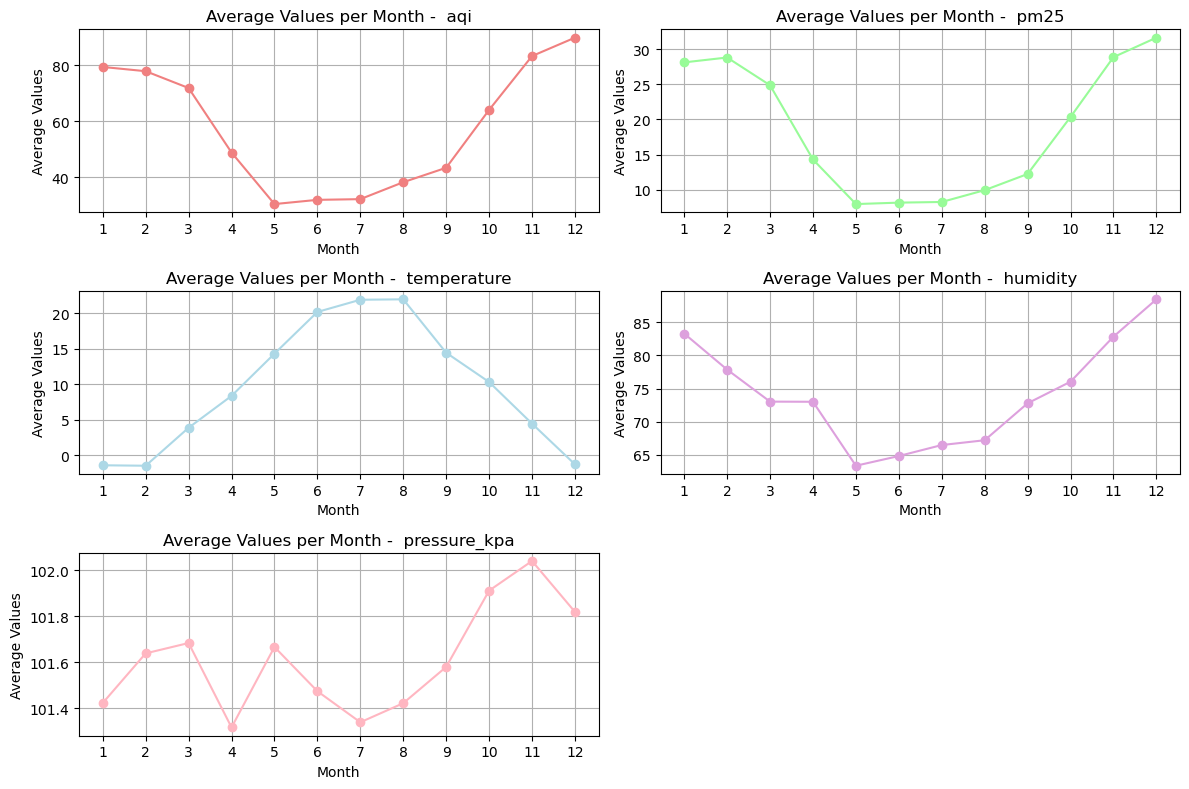

In [120]:

average_values = df.groupby(['phenomenon', 'month'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['month'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

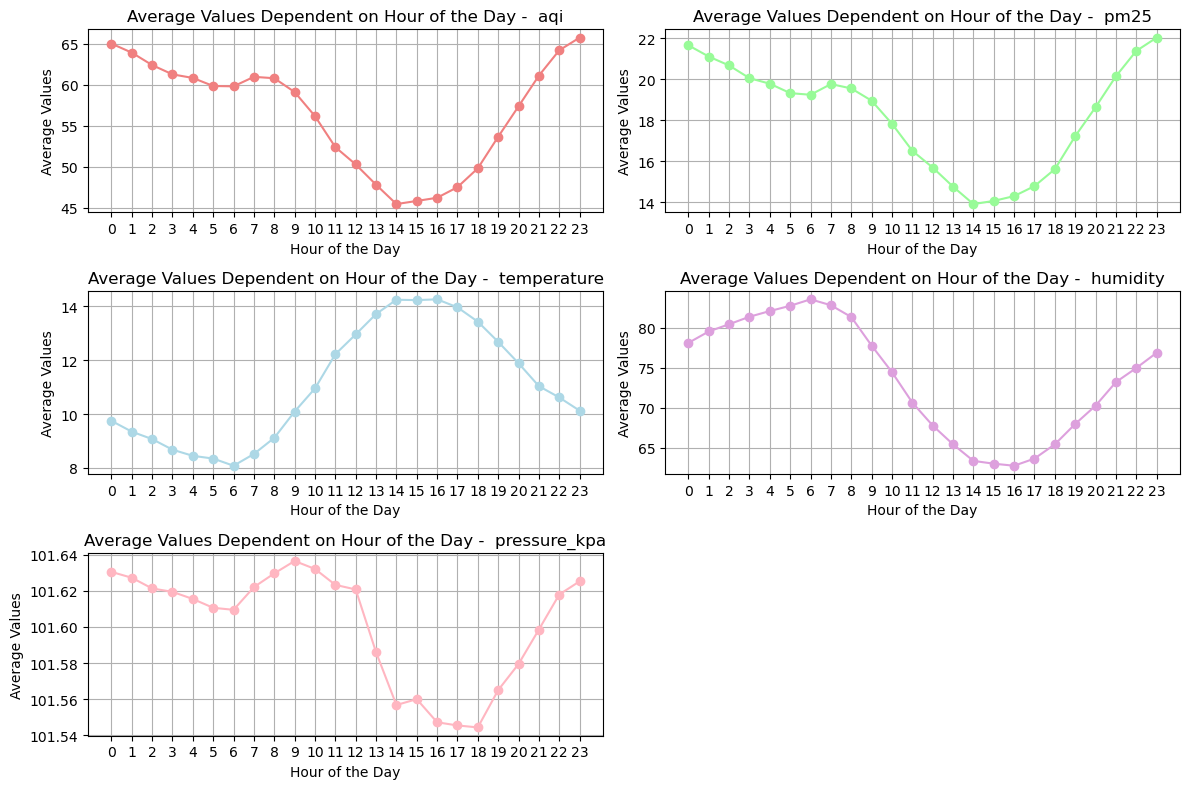

In [121]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['hour'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values Dependent on Hour of the Day -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()